# Financial Risk Analysis: Exploratory Data Assessment
**Author:** Rafael Condé Gomes  
**Project:** Quantitative Credit Risk Modeling

## 1. Executive Summary
This project aims to build a credit risk engine capable of distinguishing between profitable lending opportunities and probable defaults. Before modeling, we must understand the economic structure of the portfolio.

**Key Objectives for this Notebook:**
1.  **Data Health:** Assess missingness, data types, and class imbalance.
2.  **Risk Drivers:** Analyze how FICO, Debt-to-Income (DTI), and utilization rates correlate with default.
3.  **Pricing Efficiency:** Determine if higher interest rates accurately compensate for higher risk.

In [8]:
# System Imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import src.config as cfg
from src.data_pipeline import load_data
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'serif'

## 2. Data Loading & Structure
We utilize a centralized `load_data` function that pre-calculates financial metrics (like `principal`) to ensure consistency between this analysis and the production pipeline.

In [9]:
# Load data with engineered financial features
X, y = load_data()
df = pd.concat([X, y], axis=1)

print(f"Portfolio Size: {df.shape[0]:,} loans")
print(f"Feature Count:  {df.shape[1]} variables")
print("-" * 30)
print("Class Imbalance (Default Rate):")
print(df[cfg.TARGET].value_counts(normalize=True).map('{:.2%}'.format))

# Quick view of the financial engine
df[['installment', 'int.rate', 'principal', 'not.fully.paid']].head()

Portfolio Size: 9,578 loans
Feature Count:  15 variables
------------------------------
Class Imbalance (Default Rate):
not.fully.paid
0    83.99%
1    16.01%
Name: proportion, dtype: object


,installment,int.rate,principal,not.fully.paid
0,829.10,0.1189,25001.661439,0
1,228.22,0.1071,7000.279673,0
2,366.86,0.1357,10799.797740,0
3,162.34,0.1008,5025.265661,0
4,102.92,0.1426,3000.229254,0


### 3. Univariate Analysis: The Applicant Profile
We examine the distribution of FICO scores and Interest Rates. In a healthy portfolio, we expect a normal distribution of credit scores, skewed slightly towards higher credit (prime borrowers).

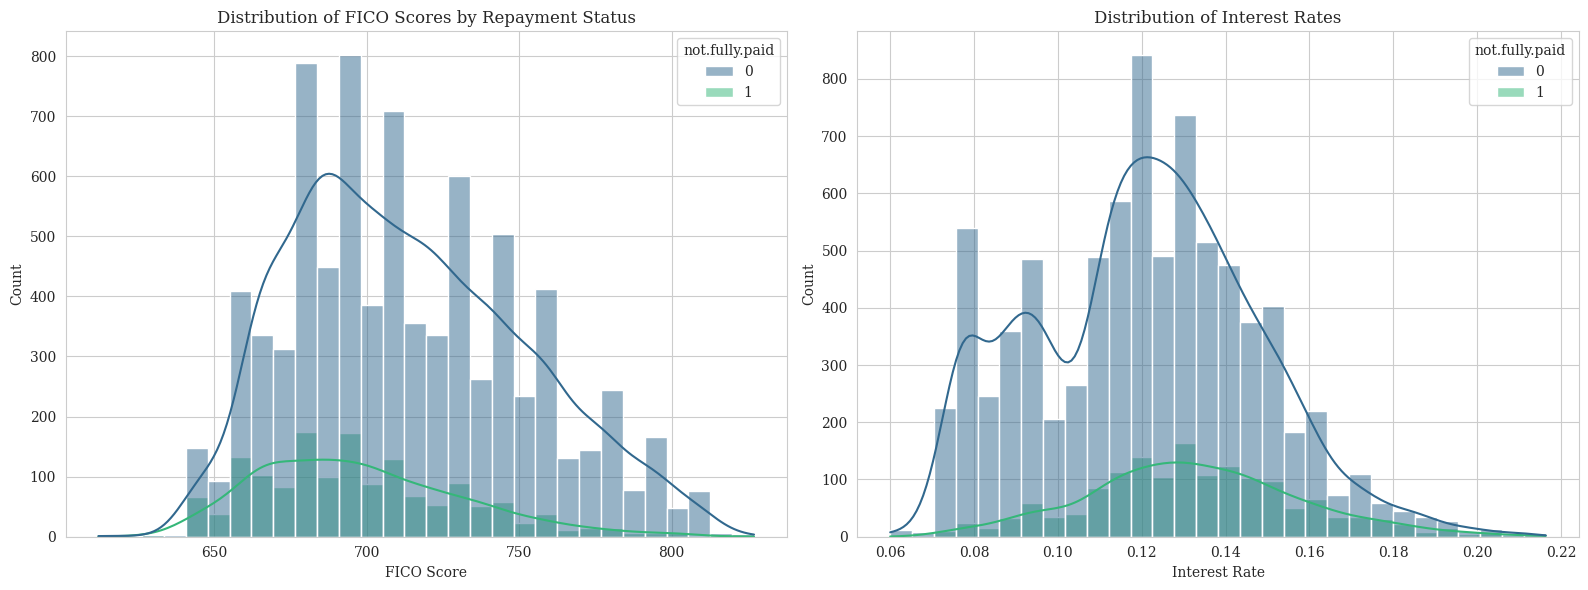

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# FICO Distribution
sns.histplot(data=df, x='fico', hue='not.fully.paid', kde=True, bins=30, palette='viridis', ax=ax[0])
ax[0].set_title('Distribution of FICO Scores by Repayment Status')
ax[0].set_xlabel('FICO Score')

# Interest Rate Distribution
sns.histplot(data=df, x='int.rate', hue='not.fully.paid', kde=True, bins=30, palette='viridis', ax=ax[1])
ax[1].set_title('Distribution of Interest Rates')
ax[1].set_xlabel('Interest Rate')

plt.tight_layout()
plt.show()

**Observation:**
* **FICO Separation:** There is a visible shift. Borrowers who fully pay (Blue) tend to have higher FICO scores. The Default group (Red) has a "fatter" left tail, indicating lower credit quality.
* **Pricing:** Interest rates are higher for the default group, suggesting the lender *attempted* to price in the risk, but perhaps not aggressively enough.


## 4. Bivariate Analysis: Risk Factors vs. Default
Does the purpose of the loan matter? Are "Debt Consolidation" loans riskier than "Credit Card" refinancing?

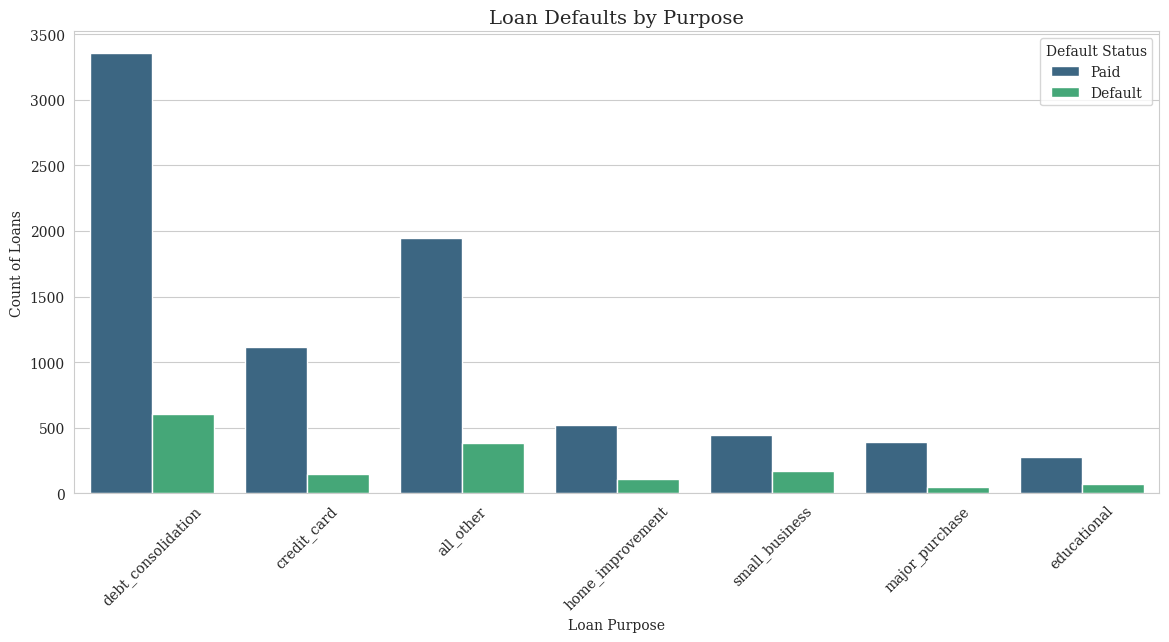

In [11]:
plt.figure(figsize=(14, 6))
sns.countplot(x='purpose', hue='not.fully.paid', data=df, palette='viridis')
plt.title('Loan Defaults by Purpose', fontsize=14)
plt.xlabel('Loan Purpose')
plt.ylabel('Count of Loans')
plt.xticks(rotation=45)
plt.legend(title='Default Status', labels=['Paid', 'Default'])
plt.show()


### 5. The "Quant" View: The Efficient Frontier of Pricing
A critical question in quantitative finance is: **"Are we being paid enough to take this risk?"**

Below, we plot FICO Score vs. Interest Rate.
* **Hypothesis:** As FICO decreases (higher risk), Interest Rate should increase linearly or exponentially.
* **Goal:** Identify if there are "cheap" loans (Low Rate, Low FICO) which represent mispricing.

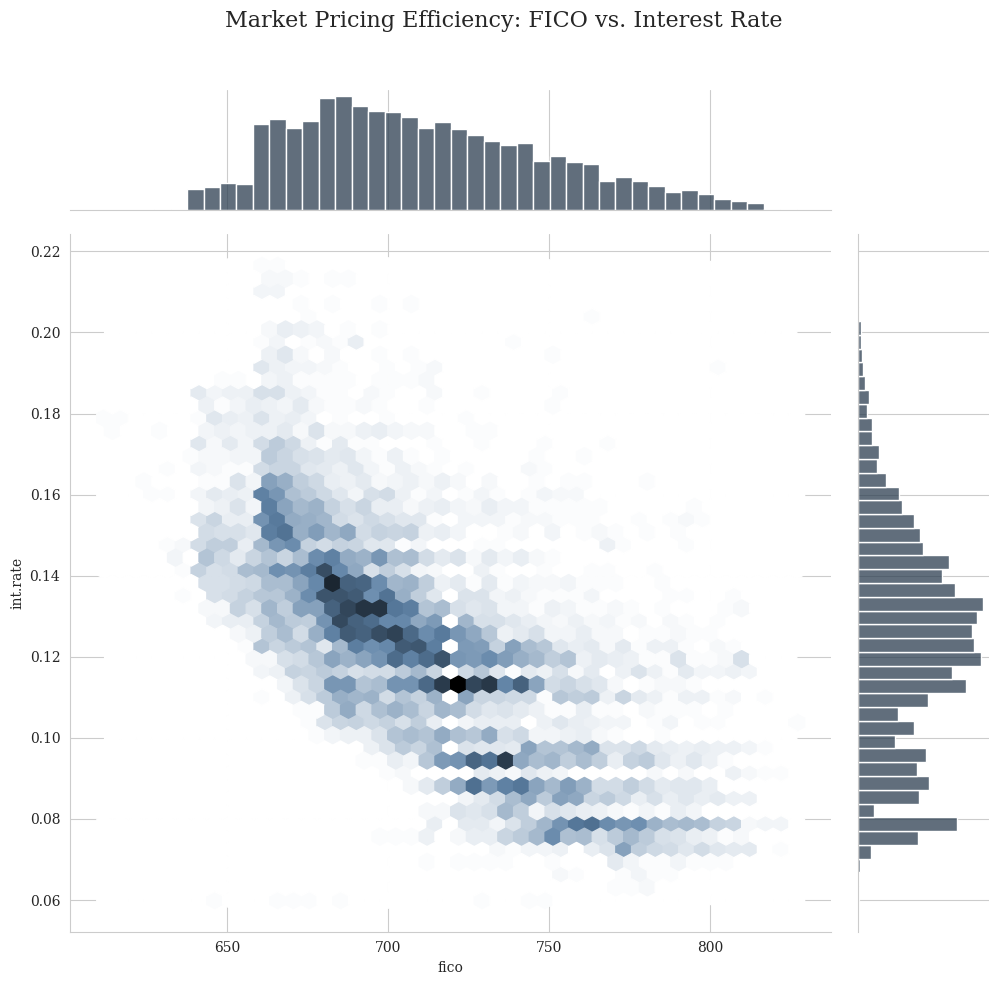

In [12]:
sns.jointplot(x='fico', y='int.rate', data=df, kind='hex', color='#2c3e50', height=10)
plt.subplots_adjust(top=0.9)
plt.suptitle('Market Pricing Efficiency: FICO vs. Interest Rate', fontsize=16)
plt.show()

**Insight:**
The negative correlation confirms the market is rational: lower scores get higher rates. However, the dispersion (width of the cloud) suggests that FICO alone does not explain pricing—other factors (Debt-to-Income, Purpose) are influencing the rate. Our model must capture these non-linearities.

## 6. Correlation Analysis
We verify collinearity between features. High correlation between variables (e.g., FICO and Interest Rate) can distort linear models (like Logistic Regression) but is generally handled well by Tree-based models (XGBoost).

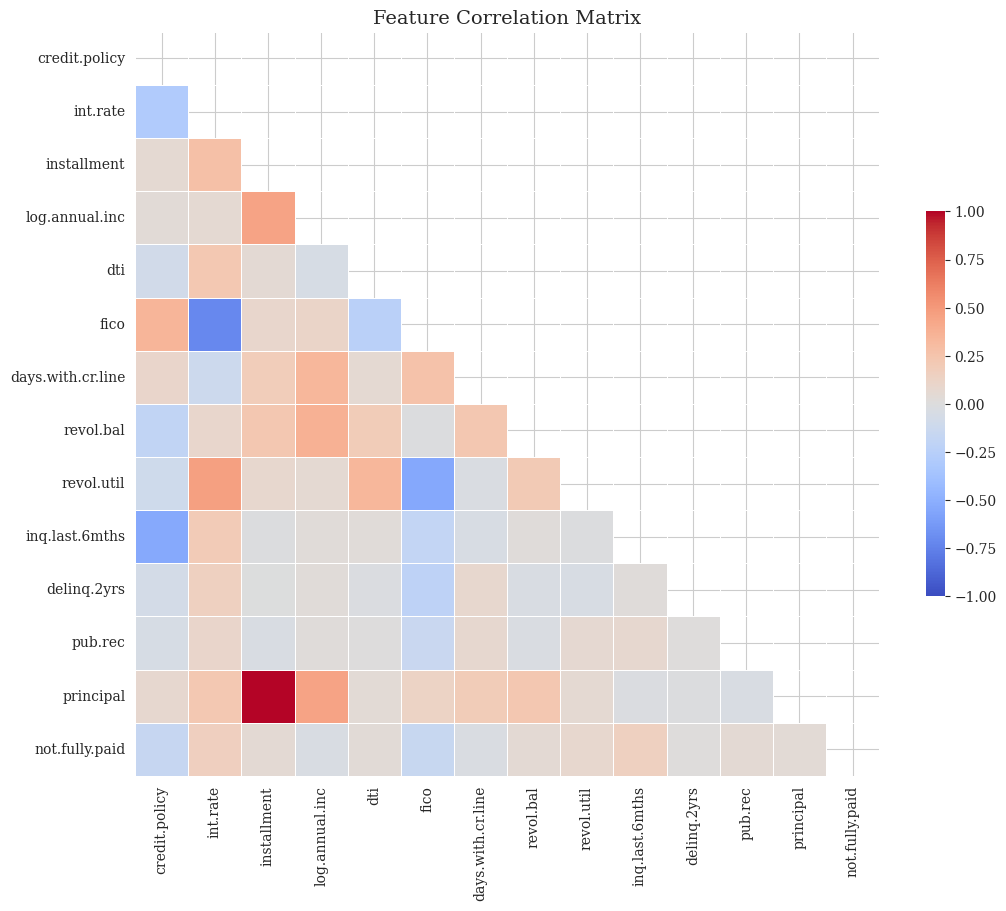

In [13]:
plt.figure(figsize=(12, 10))

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Mask the upper triangle for cleanliness
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

## 7. Conclusion & Modeling Strategy

### Key Findings
1.  **Imbalance:** The dataset is imbalanced (~16% default rate). We must use stratified splitting and potentially class weighting (scale_pos_weight).
2.  **Signal:** FICO and Interest Rate are strong univariate predictors, but the overlap between classes suggests we need multivariate non-linear models (Random Forest / XGBoost) to separate the "risky" from the "safe."
3.  **Pricing:** The market pricing is efficient but noisy. There is room for a model to identify "overpriced" risk (good loans looked bad) and "underpriced" risk (bad loans looked good).

### Next Steps
Proceed to `02_model_development.ipynb` to build the training pipeline using the **System-Level Architecture** defined in `src/`.